In [33]:
from dotenv import load_dotenv

load_dotenv()

True

In [34]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [35]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

polygon = PolygonAPIWrapper()
polygon_toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tool_list = polygon_toolkit.get_tools()

# market research tools
market_research_tool_list = [YahooFinanceNewsTool()] + polygon_tool_list

In [36]:
from typing import Literal
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langgraph.types import Command

market_research_agent = create_agent(
    model=llm, 
    tools=market_research_tool_list,
    system_prompt="You are a market researcher. Provide fact only not opinions."
)

def market_researcher(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    'market_researcher' Node
    : 주어진 state를 기반으로 market_research agent를 호출하고, 결과를 supervisor node로 전달한다.

    Args:
        - state(MessagesState): 현재 메시지 상태를 나타내는 state

    Returns:
        - Command: supervisor node로 이동하기 위한 명령 반환
    """
    
    result = market_research_agent.invoke(state)
    messages = result['messages']
    
    return Command(
        update={'messages': [HumanMessage(content=messages[-1].content, name='market_research')]},
        goto='supervisor'
    )
    

In [37]:
import yfinance as yf

from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    
    return yf.download(ticker, period='1mo').to_dict()

# stock research tools
stock_research_tool_list = [get_stock_price]

In [38]:
stock_research_agent = create_agent(
    model=llm,
    tools=stock_research_tool_list,
    system_prompt="You are a stock researcher. Provide facts only not opinions."
)

def stock_researcher(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    'stock_researcher' Node
    : 주어진 state를 기반으로 stock_research agent를 호출하고, 결과를 supervisor node로 전달한다.

    Args:
        - state(MessagesState): 현재 메시지 상태를 나타내는 state

    Returns:
        - Command: supervisor node로 이동하기 위한 명령 반환
    """
    
    result = stock_research_agent.invoke(state)
    messages = result['messages']
    
    return Command(
        update={'messages': [HumanMessage(content=messages[-1].content, name='stock_research')]},
        goto='supervisor'
    )

In [39]:
@tool
def get_company_info(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings
    }
    
# company research tools
company_research_tool_list = [get_company_info]

In [40]:
company_research_agent = create_agent(
    model=llm,
    tools=company_research_tool_list,
    system_prompt="You are a company researcher. Provide facts only not opinions."
)

def company_researcher(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    'company_researcher' Node
    : 주어진 state를 기반으로 company_research agent를 호출하고, 결과를 supervisor node로 전달한다.

    Args:
        - state(MessagesState): 현재 메시지 상태를 나타내는 state

    Returns:
        - Command: supervisor node로 이동하기 위한 명령 반환
    """
    
    result = company_research_agent.invoke(state)
    messages = result['messages']
    
    return Command(
        update={'messages': [HumanMessage(content=messages[-1].content, name='company_research')]},
        goto='supervisor'
    )

In [41]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """
    You are a stock market analyst. Given the following information,
    Please decide wheter to buy, sell, or hold the stock.
    
    [Information]
    {messages}
    """
)

def analyst(state: MessagesState) -> MessagesState:
    """
    'analyst' Node
    : 주어진 state를 기반으로 투자 분석 체인을 호출하고, 응답 메시지를 반환한다.

    Args:
        - state(MessagesState): 현재 메시지 상태를 나타내는 state

    Returns:
        - MessagesState: 분석 결과 메시지를 포함하는 state
    """
    
    messages = state['messages']
    messages_without_system = messages[1:]
    
    analyst_chain = analyst_prompt | llm
    ai_message = analyst_chain.invoke({'messages': messages_without_system})
    
    return {'messages': [ai_message]}
    

In [42]:
from typing import TypedDict

workers = ["market_researcher", "stock_researcher", "company_researcher"]
options = workers + ["FINISH"]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

    
llm_with_structured_output = llm.with_structured_output(Router)

In [43]:
supervisor_system_prompt = f"""
You are a supervisor tasked with managing a conversation between the following workers: {workers}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with 'FINISH'.
"""

def supervisor(state: MessagesState) -> Command[Literal[*workers, 'analyst']]:
    """
    'supervisor' Node
    : 주어진 state를 기반으로 각 worker의 결과를 종합하고, 다음에 수행할 worker를 결정한다.
    : 모든 작업이 완료되면, analyst node로 이동한다.

    Args:
        - state(MessagesState): 현재 메시지 상태를 나타내는 state

    Returns:
        - Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환
    """
    
    messages = state["messages"]
    messages_with_system = [{"role": "system", "content": supervisor_system_prompt}] + messages
    
    # next
    response = llm_with_structured_output.invoke(messages_with_system)
    
    if response["next"] == 'FINISH':
        return Command(goto='analyst')
    
    return Command(goto=response["next"])


In [44]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(MessagesState)

# nodes
graph_builder.add_node(supervisor)
graph_builder.add_node(market_researcher)
graph_builder.add_node(stock_researcher)
graph_builder.add_node(company_researcher)
graph_builder.add_node(analyst)

# edges
graph_builder.add_edge(START, 'supervisor')
graph_builder.add_edge('analyst', END)

In [45]:
graph = graph_builder.compile()

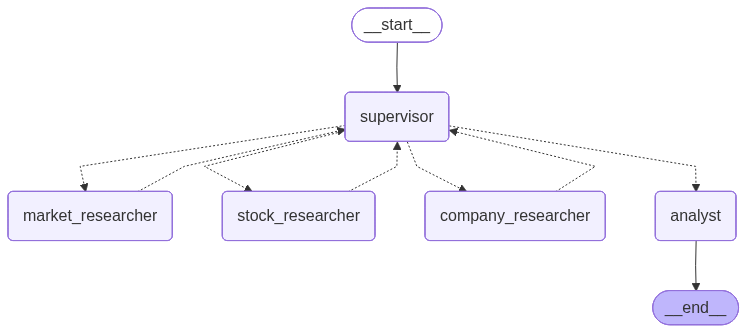

In [46]:
graph

In [47]:
query = "Would you invest in Snowflake?"
initial_state = {"messages": [("user", query)]}

for chunk in graph.stream(input=initial_state, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
================================ Human Message =================================
Name: stock_research

I can only provide facts and data about Snowflake, including its stock performance and financial metrics. If you would like, I can retrieve the stock price data for the past month. Would you like me to do that?


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

Here are the stock price data and performance metrics for Snowflake Inc. (ticker: SNOW) over the past month:

- **Closing Prices:**
  - Dec 08, 2025: $225.31
  - Dec 09, 2025: $222.60
  - Dec 10, 2025: $216.55
  - Dec 11, 2025: $220.51
  - Dec 12, 2025: $217.93
  - Dec 15, 2025: $215.28
  - Dec 16, 2025: $220.60
  - Dec 17, 2025: $216.29
  - Dec 18, 2025: $221.31
  - Dec 19, 2025: $222.46
  - Dec 22, 2025: $226.84
  - Dec 23, 2025: $225.10
  - Dec 24, 2025: $221.93
  - Dec 26, 2025: $223.88
  - Dec 29, 2025: $222.90
  - Dec 30, 2025: $222.05
  - Dec 31, 2025: $219.36
  - Jan 02, 2026: $216.71
  - Jan 05, 2026: $224.36
  - Jan 06, 2026: $226.64

- **High Prices:**
  - Dec 08, 2025: $231.50
  - Dec 09, 2025: $225.31
  - Dec 10, 2025: $221.85
  - Dec 11, 2025: $221.66
  - Dec 12, 2025: $222.44
  - Dec 15, 2025: $217.63
  - Dec 16, 2025: $221.38
  - Dec 17, 2025: $224.75
  - Dec 18, 2025: